<a href="https://colab.research.google.com/github/Nicolas-Saade/Deep-Learning-Image-Classification/blob/main/ImagClassificationBees%26Ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Image Classification with PyTorch: Bees and Ants***

Welcome to my image classification project! In this notebook, I will be making use of the PyTorch deep learning library to distinguish images containing two types of insects: bees and ants. Using transfer learning on a pre-trained ResNet-18 model, I fine-tuned the model leveraging data augmentation techniques on a small dataset in classification tasks that had its parameters optimized to minimize Cross Entropy Loss and Accuarcy.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.7MB/s]


Epoch 0/24
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.5855 Acc: 0.7049
val Loss: 0.2292 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5232 Acc: 0.7746
val Loss: 0.1997 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4785 Acc: 0.8156
val Loss: 0.2929 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4922 Acc: 0.7992
val Loss: 0.2465 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4515 Acc: 0.8361
val Loss: 0.1609 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4254 Acc: 0.8033
val Loss: 0.1474 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4840 Acc: 0.8074
val Loss: 0.4067 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4543 Acc: 0.8197
val Loss: 0.2343 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4521 Acc: 0.8402
val Loss: 0.2681 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3764 Acc: 0.8238
val Loss: 0.2362 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3261 Acc: 0.8484
val Loss: 0.2381 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2963 Acc: 0.8730
val Loss: 0.2160 Acc: 0.9281

Epoch 12/24
----------
t

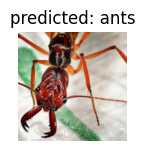

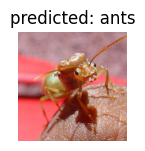

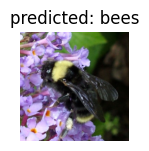

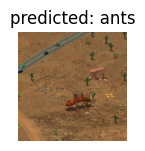

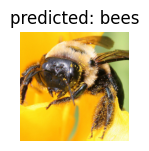

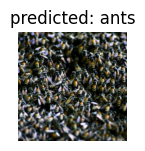

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader

cudnn.benchmark = True
plt.ion()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = { #  This is a Python dictionary
    # it defines two sets of data transformations:
    # one for the "train" dataset and another for the "val" (validation) dataset
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # data augmentation techniques to increase robustness of the model
        transforms.RandomHorizontalFlip(),  # data augmentation techniques to increase robustness of the model
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data' # path of the dataset

# the coming line creates 2 dataset objects for the dataset split: train and test
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# the coming line creates 2 dataloader objects for the dataset split: train and test
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# It stores the number of samples in each dataset split
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# stores the class names or labels for the train dataset, in this case it would be bees and ants.
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # this records the current time as the starting time

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt') # This line creates a file path
        # by joining the temporary directory tempdir and the file name best_model_params.pt.
        # This path will be used to save the model's best parameters during training.

        torch.save(model.state_dict(), best_model_params_path) #  This line saves the initial state of the model
        # (before training) as a dictionary of its parameters to the best_model_params_path.
        best_acc = 0.0  # This line initializes a variable best_acc
        # to keep track of the best accuracy achieved during training.

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:  # This line starts a nested loop that iterates over two phases:
                # "train" and "val" (validation). In the training phase,
                # the model will be trained, and in the validation phase, it will be evaluated.
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0  # keeps track of the cumulative loss during the epoch
                running_corrects = 0    # keeps track of the number of correct predictions during the epoch.

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:   # This line iterates over the data batches in the current phase ("train" or "val")
                    # using the corresponding dataloader
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):  # This line sets the gradient calculation mode
                        # based on the current phase.
                        # Gradients are only computed during training (phase == 'train'), not during validation.
                        outputs = model(inputs)     # This line passes the input data (inputs) through the model to get the predicted outputs
                        _, preds = torch.max(outputs, 1)    # gives us the predicted class labels, and finds the index of the highest class probability
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()     # This line performs backpropagation to compute the gradients of the model's parameters with respect to the loss.
                            optimizer.step()    # This line updates the model's parameters using the computed gradients

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()    # adjusts the learning rate of the optimizer based on the schedulizer

                epoch_loss = running_loss / dataset_sizes[phase]    # calculates average loss
                epoch_acc = running_corrects.double() / dataset_sizes[phase]    # calculates accuarcy

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc: # checks if the current phase accuarcy is better than the best previous one
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since  # calculates total time taken
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

def visualize_model(model, num_images=6):
    was_training = model.training   # stores the current training mode of the model
    model.eval()    # sets the model to evaluation mode
    images_so_far = 0   # keeps track of the number of images processed so far
    fig = plt.figure()  # Creates a new figure for visualization using matplotlib

    with torch.no_grad():   # creates a context in which no gradients will be computed.
        # It's useful during inference when we don't need gradients for backpropagation.
        for i, (inputs, labels) in enumerate(dataloaders['val']):   # Iterates over the validation data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)    # finds the index of the maximum value along the second dimension (class probabilities)
            # of the outputs. It gives us the predicted class labels.

            for j in range(inputs.size()[0]):   # iterates over the images in the current batch.
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)  # This line restores the original training mode of the model
                    return
        model.train(mode=was_training)  # This line restores the original training mode of the model

model_ft = models.resnet18(weights='IMAGENET1K_V1') # we create an instance of the ResNet-18 model architecture
# using torchvision.models.resnet18. The 'weights' argument is set to 'IMAGENET1K_V1'

num_ftrs = model_ft.fc.in_features  # The ResNet-18 model consists of a fully connected layer (fc) at the end,
# which is responsible for the final classification.
# Here, we extract the number of input features (num_ftrs) of the last fully connected layer.

model_ft.fc = nn.Linear(num_ftrs, 2)    # In this line, we replace the existing fully connected layer (fc)
# of the ResNet-18 model with a new nn.Linear layer.
# The new layer has num_ftrs input features and 2 output features.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()   # Here, we define the loss function that will be used to train the model.

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

visualize_model(model_ft)

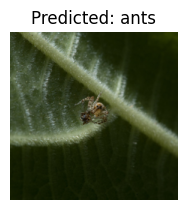

In [25]:
def visualize_model_predictions(model,img_path):
    was_training = model.training   # current training mode of the model
    model.eval()   # sets the model to evaluation mode

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)  # reformats the image to be accepted in a neural network
    img = img.to(device)

    with torch.no_grad():   # eliminates gradient computation
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)  # This line restores the original training mode of the model.

visualize_model_predictions(
    model_ft,
    img_path='/content/hymenoptera_data/val/ants/1247887232_edcb61246c.jpg'
)

plt.ioff()
plt.show()

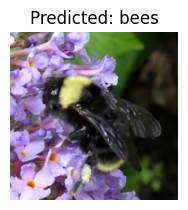

In [30]:
visualize_model_predictions(
    model_ft,
    img_path='/content/hymenoptera_data/val/bees/936182217_c4caa5222d.jpg'
)

plt.ioff()
plt.show()

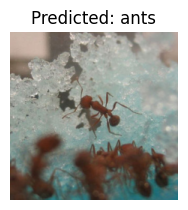

In [31]:
visualize_model_predictions(
    model_ft,
    img_path='/content/hymenoptera_data/train/ants/6240329_72c01e663e.jpg'
)

plt.ioff()
plt.show()

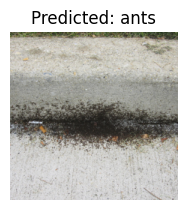

In [33]:
visualize_model_predictions(
    model_ft,
    img_path='/content/hymenoptera_data/val/ants/212100470_b485e7b7b9.jpg'
)

plt.ioff()
plt.show()